In [1]:
import sklearn
from config import config
import psycopg2
from psycopg2 import Error
import pandas.io.sql as psql
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import numpy as np
# from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import NearMiss
from sklearn.feature_selection import RFECV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Import data from database

In [2]:
# output records from a query as a dataframe 
def get_dataframe(query):
    try:
        # Connect to an existing database
        params = config()
        connection = psycopg2.connect(**params)

    #     cursor = connection.cursor()  
    #     cursor.execute(query)
    #     records = cursor.fetchall()

        df = psql.read_sql(query, connection)


    except (Exception, Error) as error:
        print("Error while connecting to PostgreSQL", error)
    finally:
        if (connection):
            #cursor.close()
            connection.close()
            
    return df


fact_df = get_dataframe("SELECT * FROM fact")
print(fact_df.shape)

(47905, 14)


In [3]:
# tables to get: date, fact, holiday, mobility_trends, person, phu, restriction, restriction_group, 
# restriction_group_bridge, weather

# date_df = get_dataframe("SELECT * FROM date")
fact_df = get_dataframe("SELECT * FROM fact")
# holiday_df = get_dataframe("SELECT * FROM holiday")
mobility_trends_df = get_dataframe("SELECT * FROM mobility_trends") #Aisha
person_df = get_dataframe("SELECT * FROM person") # shouldn't we used names from mobility_trends instead?
# phu_df = get_dataframe("SELECT * FROM phu") # need name attributes
# restriction_df = get_dataframe("SELECT * FROM restriction")
# restriction_group_df = get_dataframe("SELECT * FROM restriction_group")
# restriction_group_bridge_df = get_dataframe("SELECT * FROM restriction_group_bridge")
weather_df = get_dataframe("SELECT * FROM weather") # Aisha

In [4]:
mobility_trends_df

,mobility_key,country,province,municipality,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,0,Canada,Ontario,Ottawa,-26.0,-9.0,181.0,-32.0,-2.0,0.0
1,1,Canada,Ontario,Ottawa,-25.0,-11.0,2.0,-46.0,-7.0,3.0
2,2,Canada,Ontario,Ottawa,-35.0,-24.0,137.0,-67.0,-77.0,17.0
3,3,Canada,Ontario,Ottawa,-27.0,-8.0,-21.0,-62.0,-61.0,19.0
4,4,Canada,Ontario,Ottawa,-20.0,1.0,59.0,-60.0,-58.0,17.0
...,...,...,...,...,...,...,...,...,...,...
727,727,Canada,Ontario,Toronto,-44.0,-10.0,-9.0,-60.0,-48.0,20.0
728,728,Canada,Ontario,Toronto,-45.0,-14.0,-8.0,-59.0,-47.0,20.0
729,729,Canada,Ontario,Toronto,-43.0,-11.0,34.0,-49.0,-14.0,10.0
730,730,Canada,Ontario,Toronto,-43.0,-15.0,42.0,-50.0,-19.0,8.0


## Data Transformation

In [5]:
combined_df = fact_df.drop(['test_date_id', 'reported_date_id', 'specimen_date_id', 'onset_date_id'], axis = 1)

In [6]:
# combined_df.merge(mobility_trends_df, left_on = ['loc_id'], right_on = ['mobility_key'], how = 'left').drop(['mobility_key'], axis = 1)
# combined_df.merge(weather_df, left_on = ['weather_id'], right_on = ['weather_key'], how = 'left').drop(['weather_key','longitude','latitude','station_name'], axis = 1)
# combined_df.merge(person_df, left_on = ['person_id'], right_on = ['person_id'], how = 'left').drop(['person_id'], axis = 1)


In [7]:
combined_df = combined_df.merge(mobility_trends_df, left_on = ['loc_id'], right_on = ['mobility_key'], how = 'left').drop(['mobility_key', 'country', 'province'], axis = 1)
combined_df = combined_df.merge(weather_df, left_on = ['weather_id'], right_on = ['weather_key'], how = 'left').drop(['weather_key','longitude','latitude','station_name'], axis = 1)
combined_df = combined_df.merge(person_df, left_on = ['person_id'], right_on = ['person_id'], how = 'left').drop(['person_id'], axis = 1)


In [8]:
len(combined_df.columns) # 29 columns
# len(combined_df) # 47905 rows

23

In [9]:
cols = list(combined_df.columns.values) #Make a list of all of the columns in the combined_df
cols.pop(cols.index('age_group')) #Remove age_group from list
combined_df = combined_df[cols+['age_group']]

In [10]:
combined_df

,holiday_id,loc_id,weather_id,restriction_group_id,test_facility_id,resolved,unresolved,fatal,outbreak,municipality,...,transit_stations,workplaces,residential,mean_tempreture,total_precipitation_mm,snow,rain,gender,case_acquisition,age_group
0,0,77,77,14,3,1,0,0,0,Ottawa,...,-46.0,-7.0,6.0,6.8,0.0,False,False,MALE,CC,50s
1,0,577,211,14,4,1,0,0,0,York,...,-58.0,-43.0,19.0,6.5,1.6,False,True,MALE,CC,80s
2,0,488,122,0,4,1,0,0,0,York,...,-29.0,-12.0,2.0,24.4,3.8,False,True,MALE,OB,30s
3,0,488,122,0,4,1,0,0,0,York,...,-29.0,-12.0,2.0,24.4,3.8,False,True,MALE,CC,90+
4,39,123,123,0,5,1,0,0,0,Durham,...,-27.0,-13.0,3.0,24.0,37.0,False,True,FEMALE,CC,40s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47900,0,724,236,14,2,1,0,0,0,Toronto,...,-62.0,-50.0,20.0,-0.4,0.0,False,False,MALE,CC,80s
47901,0,679,191,13,2,1,0,0,0,Toronto,...,-50.0,-45.0,15.0,10.6,0.0,False,False,MALE,CC,80s
47902,0,589,223,14,4,1,0,0,0,York,...,-56.0,-43.0,17.0,16.1,0.0,False,False,MALE,OB,30s
47903,54,590,224,14,4,1,0,0,0,York,...,-58.0,-45.0,18.0,11.9,0.6,False,True,MALE,CC,90+


### Target Categorization

In [11]:
age_group_vals = list(combined_df['age_group'].unique())
age_group_vals

['50s', '80s', '30s', '90+', '40s', '70s', '60s', '<20', '20s', nan]

In [12]:
combined_df['age_group'] = combined_df['age_group'].apply(lambda x: '50' if (x == '50s') else x)
combined_df['age_group'] = combined_df['age_group'].apply(lambda x: '80' if (x == '80s') else x)
combined_df['age_group'] = combined_df['age_group'].apply(lambda x: '30' if (x == '30s') else x)
combined_df['age_group'] = combined_df['age_group'].apply(lambda x: '90' if (x == '90+') else x)
combined_df['age_group'] = combined_df['age_group'].apply(lambda x: '40' if (x == '40s') else x)
combined_df['age_group'] = combined_df['age_group'].apply(lambda x: '70' if (x == '70s') else x)
combined_df['age_group'] = combined_df['age_group'].apply(lambda x: '60' if (x == '60s') else x)
combined_df['age_group'] = combined_df['age_group'].apply(lambda x: '20' if (x == '20s') else x)
combined_df['age_group'] = combined_df['age_group'].apply(lambda x: '0' if (x == '<20') else x)

In [13]:
combined_df

,holiday_id,loc_id,weather_id,restriction_group_id,test_facility_id,resolved,unresolved,fatal,outbreak,municipality,...,transit_stations,workplaces,residential,mean_tempreture,total_precipitation_mm,snow,rain,gender,case_acquisition,age_group
0,0,77,77,14,3,1,0,0,0,Ottawa,...,-46.0,-7.0,6.0,6.8,0.0,False,False,MALE,CC,50
1,0,577,211,14,4,1,0,0,0,York,...,-58.0,-43.0,19.0,6.5,1.6,False,True,MALE,CC,80
2,0,488,122,0,4,1,0,0,0,York,...,-29.0,-12.0,2.0,24.4,3.8,False,True,MALE,OB,30
3,0,488,122,0,4,1,0,0,0,York,...,-29.0,-12.0,2.0,24.4,3.8,False,True,MALE,CC,90
4,39,123,123,0,5,1,0,0,0,Durham,...,-27.0,-13.0,3.0,24.0,37.0,False,True,FEMALE,CC,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47900,0,724,236,14,2,1,0,0,0,Toronto,...,-62.0,-50.0,20.0,-0.4,0.0,False,False,MALE,CC,80
47901,0,679,191,13,2,1,0,0,0,Toronto,...,-50.0,-45.0,15.0,10.6,0.0,False,False,MALE,CC,80
47902,0,589,223,14,4,1,0,0,0,York,...,-56.0,-43.0,17.0,16.1,0.0,False,False,MALE,OB,30
47903,54,590,224,14,4,1,0,0,0,York,...,-58.0,-45.0,18.0,11.9,0.6,False,True,MALE,CC,90


### Handling missing values through e.g., imputation

In [14]:
# - handling missing values through e.g., imputation, 
# -> all missing values have been removed during data staging
nan_values = combined_df[combined_df.isnull().any(axis=1)]
print(len(nan_values)) # 744 empty rows
combined_df = combined_df.dropna()
# CONCLUSION: 744 rows have been imputed
combined_df['age_group'] = combined_df['age_group'].apply(lambda x: int(x))

744


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### Handling categorical attributes through e.g., one-hot encoding or conversion to ordinal data

In [15]:
# - handling categorical attributes through e.g., one-hot encoding or conversion to ordinal data,
def oneHotEncode(df_copy): # the last column won't be encoded and only categorical data will be encoded
    
    df = df_copy.copy()
    # remove target col
    target_df = df.pop('age_group')
    
    non_numeric_cols = list(df.select_dtypes([object]).columns)
    
    df_to_encode = df[non_numeric_cols]
    
    cols_not_to_encode = []
    for col in list(df.columns):
        if col not in non_numeric_cols:
            cols_not_to_encode.append(col)
    

    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(df_to_encode)
    df_encoded = enc.fit_transform(df_to_encode)
    old_features = list(df_to_encode.columns.values)
    new_features = enc.get_feature_names(old_features)
    df_encoded = pd.DataFrame(df_encoded.toarray(), columns = new_features)
    
    for col in cols_not_to_encode:
        df_encoded[col] = df[col]
        
    # re-adding target col
    df_encoded['age_group'] = target_df
    df_encoded = df_encoded.dropna()
    
    return df_encoded

combined_df_encoded = oneHotEncode(combined_df)
# combined_df_encoded.info()
# combined_df_encoded[combined_df_encoded.isnull().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46421 entries, 0 to 47160
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   municipality_Durham                    46421 non-null  float64
 1   municipality_Halton                    46421 non-null  float64
 2   municipality_Ottawa                    46421 non-null  float64
 3   municipality_Peel                      46421 non-null  float64
 4   municipality_Toronto                   46421 non-null  float64
 5   municipality_York                      46421 non-null  float64
 6   gender_FEMALE                          46421 non-null  float64
 7   gender_MALE                            46421 non-null  float64
 8   case_acquisition_CC                    46421 non-null  float64
 9   case_acquisition_NO KNOWN EPI LINK     46421 non-null  float64
 10  case_acquisition_OB                    46421 non-null  float64
 11  ca

### Normalisation of numeric attributes to ensure all attributes are of equal importance during learning

In [16]:
# - normalisation of numeric attributes to ensure all attributes are of equal importance during learning,
def normalize(df_copy):
    
    df = df_copy.copy()
    # remove target col
    target_df = df.pop('age_group')
    

    # normalize
    # get numeric cols
    numeric_cols = list(df.select_dtypes([np.int64,np.float64]).columns)
    
    cols_to_not_normalize = []
    cols_to_normalize = []
    for col in numeric_cols:
        if col.endswith("_id"):
            cols_to_not_normalize.append(col)
        else:
            cols_to_normalize.append(col)
    
    df_not_normalized = df[cols_to_not_normalize]
    df_normalized = df[cols_to_normalize]
    x = df_normalized.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_normalized = pd.DataFrame(x_scaled, columns = cols_to_normalize)

    # add non_numeric cols to df_normalized
    non_numeric_cols = list(df.select_dtypes([object]).columns)
    
    for i in non_numeric_cols:
        df_temp = df.pop(i)
        df_normalized[i] = df_temp
        
    #df_non_numeric = df[]
    # re-adding target col
    for col in cols_to_not_normalize:
        df_normalized[col] = df_not_normalized[col]
        
    df_normalized['age_group'] = target_df
    
    df_normalized = df_normalized.dropna()
    return df_normalized



,resolved,unresolved,fatal,outbreak,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,...,total_precipitation_mm,municipality,gender,case_acquisition,holiday_id,loc_id,weather_id,restriction_group_id,test_facility_id,age_group
0,0.052632,0.0,0.0,0.0,0.661765,0.789474,0.391960,0.507246,0.876404,0.275862,...,0.000000,Ottawa,MALE,CC,0.0,77.0,77.0,14.0,3.0,50.0
1,0.052632,0.0,0.0,0.0,0.661765,0.868421,0.208543,0.333333,0.471910,0.724138,...,0.038278,York,MALE,CC,0.0,577.0,211.0,14.0,4.0,80.0
2,0.052632,0.0,0.0,0.0,0.632353,0.763158,0.929648,0.753623,0.820225,0.137931,...,0.090909,York,MALE,OB,0.0,488.0,122.0,0.0,4.0,30.0
3,0.052632,0.0,0.0,0.0,0.632353,0.763158,0.929648,0.753623,0.820225,0.137931,...,0.090909,York,MALE,CC,0.0,488.0,122.0,0.0,4.0,90.0
4,0.052632,0.0,0.0,0.0,0.794118,0.710526,0.213568,0.782609,0.808989,0.172414,...,0.885167,Durham,FEMALE,CC,39.0,123.0,123.0,0.0,5.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47156,0.052632,0.0,0.0,0.0,0.279412,0.539474,0.052764,0.275362,0.393258,0.758621,...,0.000000,Toronto,FEMALE,OB,0.0,731.0,243.0,14.0,2.0,40.0
47157,0.052632,0.0,0.0,0.0,0.573529,0.828947,0.223618,0.449275,0.449438,0.586207,...,0.000000,Peel,MALE,CC,0.0,487.0,243.0,14.0,0.0,20.0
47158,0.052632,0.0,0.0,0.0,0.705882,0.842105,0.482412,0.362319,0.471910,0.655172,...,0.000000,Toronto,MALE,CC,0.0,731.0,243.0,14.0,2.0,80.0
47159,0.052632,0.0,0.0,0.0,0.779412,0.868421,0.344221,0.333333,0.449438,0.689655,...,0.014354,Peel,MALE,CC,0.0,487.0,243.0,14.0,0.0,20.0


In [ ]:
#combined_df.info()
combined_df_normalized = normalize(combined_df)
# combined_df_normalized
# combined_df_normalized[combined_df_normalized.isnull().any(axis=1)]

### Feature selection to remove potentially redundant attributes

In [60]:
# - feature selection to remove potentially redundant attributes, and

def fs(df, target, n):
    predictors = [x for x in combined_df_normalized_encoded.columns if x not in [target]]
    X = df[predictors]
    y = df[target]
    
    estimator = DecisionTreeClassifier(random_state=0)
    selector = RFECV(estimator, step = 2, cv = 5, min_features_to_select = n)
    X_fs = selector.fit_transform(X, y)

    print("Optimal number of features : %d" % selector.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(10,
                   len(selector.grid_scores_) + 10),
             selector.grid_scores_)
    plt.show()
    
    lst = selector.get_support()
    cols = list(X.columns)
    new_cols = []
    
    for i in range(len(lst)):
        if lst[i]:
            new_cols.append(cols[i])
            
    X_fs = pd.DataFrame(X_fs, columns = new_cols)
    X_fs['age_group'] = y
    
    X_fs = X_fs.dropna()
    return X_fs


Optimal number of features : 28


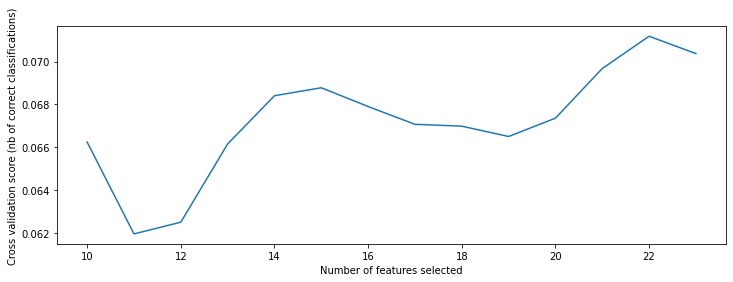

In [61]:
combined_df_normalized_encoded = oneHotEncode(combined_df_normalized)
# combined_df_normalized[combined_df_normalized.isnull().any(axis=1)]
t = 'age_group'
combined_df_normalized_encoded_fs = fs(combined_df_normalized_encoded, t, 5)
# combined_df_normalized_encoded

In [62]:
combined_df_normalized_encoded_fs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44953 entries, 0 to 45683
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   municipality_Halton                    44953 non-null  float64
 1   municipality_Ottawa                    44953 non-null  float64
 2   municipality_Peel                      44953 non-null  float64
 3   municipality_Toronto                   44953 non-null  float64
 4   municipality_York                      44953 non-null  float64
 5   gender_FEMALE                          44953 non-null  float64
 6   gender_MALE                            44953 non-null  float64
 7   case_acquisition_CC                    44953 non-null  float64
 8   case_acquisition_NO KNOWN EPI LINK     44953 non-null  float64
 9   case_acquisition_OB                    44953 non-null  float64
 10  case_acquisition_TRAVEL                44953 non-null  float64
 11  ca

In [63]:
# combined_df_normalized_encoded_fs[combined_df_normalized_encoded_fs.isnull().any(axis=1)]

,municipality_Halton,municipality_Ottawa,municipality_Peel,municipality_Toronto,municipality_York,gender_FEMALE,gender_MALE,case_acquisition_CC,case_acquisition_NO KNOWN EPI LINK,case_acquisition_OB,...,workplaces,residential,mean_tempreture,total_precipitation_mm,holiday_id,loc_id,weather_id,restriction_group_id,test_facility_id,age_group


### Undersampling of the majority class(es) to balance the class distributions

In [64]:
# - undersampling of the majority class(es) to balance the class distributions of the classification task your team selected in Part B.
def undersample(df_copy, target):
    
    df = df_copy.copy()
    nr = NearMiss()
    predictors = [x for x in df.columns if x not in [target]]
    X = df[predictors]
    y = df[target]
    X_nr, y_nr = nr.fit_sample(X, y)
    X_nr['age_group'] = y_nr
    return X_nr

In [65]:
t = 'age_group' # TEST
combined_df_normalized_encoded_fs_nr = undersample(combined_df_normalized_encoded_fs, t) # TEST

In [66]:
combined_df_normalized_encoded_fs_nr # TEST

,municipality_Halton,municipality_Ottawa,municipality_Peel,municipality_Toronto,municipality_York,gender_FEMALE,gender_MALE,case_acquisition_CC,case_acquisition_NO KNOWN EPI LINK,case_acquisition_OB,...,workplaces,residential,mean_tempreture,total_precipitation_mm,holiday_id,loc_id,weather_id,restriction_group_id,test_facility_id,age_group
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.505618,0.655172,0.356037,0.000000,0.0,713.0,225.0,14.0,2.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.471910,0.655172,0.244582,0.004785,0.0,713.0,225.0,14.0,2.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.516854,0.620690,0.374613,0.000000,0.0,713.0,225.0,14.0,2.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.516854,0.586207,0.383901,0.000000,0.0,87.0,87.0,14.0,3.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.573034,0.551724,0.421053,0.000000,0.0,719.0,231.0,14.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9976,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.831461,0.344828,0.343653,0.000000,0.0,119.0,119.0,14.0,3.0,90.0
9977,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.966292,0.241379,0.287926,0.000000,0.0,485.0,241.0,14.0,0.0,90.0
9978,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.887640,0.275862,0.343653,0.000000,0.0,729.0,241.0,14.0,2.0,90.0
9979,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.741573,0.344828,0.343653,0.000000,0.0,730.0,242.0,14.0,2.0,90.0


In [68]:
combined_df_normalized_encoded_fs_nr['age_group'].value_counts() # TEST

90.0    1109
60.0    1109
30.0    1109
70.0    1109
50.0    1109
80.0    1109
40.0    1109
20.0    1109
0.0     1109
Name: age_group, dtype: int64

In [69]:
combined_df_normalized_encoded_fs['age_group'].value_counts() # TEST

40.0    8005
50.0    6742
30.0    5955
70.0    5362
20.0    5281
60.0    4792
80.0    4557
0.0     3150
90.0    1109
Name: age_group, dtype: int64

In [70]:
# Use combined_df_normalized_encoded_fs_nr as the final dataframe
# It has 1109 sample per class, and 9 classes in total.
# Classes: 90.0 -> 90s
# 80.0 -> 80s
# 70.0 -> 70s
# 60.0 -> 60s
# 50.0 -> 50s
# 40.0 -> 40s
# 30.0 -> 30s
# 20.0 -> 20s
# 0.0 -> <20

## Part B - Classification (Supervised Learning) - Target = age_group

### Gradient Boosting